In [5]:
%pip install Pyreadstat


   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
    --------------------------------------- 0.0/2.4 MB 435.7 kB/s eta 0:00:06
   - -------------------------------------- 0.1/2.4 MB 544.7 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.4 MB 581.0 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.4 MB 654.6 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/2.4 MB 737.3 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/2.4 MB 724.0 kB/s eta 0:00:04
   ---- ----------------------------------- 0.3/2.4 MB 774.0 kB/s eta 0:00:03
   ----- ---------------------------------- 0.3/2.4 MB 756.6 kB/s eta 0:00:03
   ----- ---------------------------------- 0.4/2.4 MB 768.6 kB/s eta 0:00:03
   ------ --------------------------------- 0.4/2.4 MB 778.2 kB/s eta 0:00:03
   ------- -

Load required libraries for analysis:

In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import stepmix

from sklearn.model_selection import GridSearchCV, ParameterGrid


Load and transform required data:

In [2]:
#load the prepared dataframe from csv. 
#In this data set all variables have been transformed into quantiles except for 'attr' which has been dichotomised.
data_females = pd.read_csv("./data_females.csv")

#We also load the outcomes data.frame
y_females = pd.read_csv("./y_females.csv")

#Recode PPCS_6 and CSBD to 0 and 1. 
data_females["CSBD"] = np.where(data_females["CSBD"] == 2, 1, 0)
data_females["PPCS_6"] = np.where(data_females["PPCS_6"] == 2, 1, 0)

In [3]:
mixed_data, mixed_descriptor = stepmix.utils.get_mixed_descriptor(dataframe=data_females.drop(columns=["CASE"]), 
                                                    binary=["attr", "CSBD", "PPCS_6"], 
                                                    categorical=["sexdrive2", "meffort", "socialanx", "lon", "mvalue"])

In [14]:
mixed_data

,attr,CSBD,PPCS_6,sexdrive2,meffort,socialanx,lon,mvalue
0,0,1,1,3,3,3,4,2
1,0,1,1,1,4,4,4,4
2,0,1,0,4,3,3,1,2
3,0,1,1,4,4,3,3,3
4,0,0,1,2,1,3,1,2
...,...,...,...,...,...,...,...,...
1415,0,1,0,3,3,3,3,1
1416,1,1,1,3,2,4,4,1
1417,0,1,1,2,2,4,4,3
1418,1,1,0,1,4,1,2,3


In [5]:
#Try out a model with 3 classes
model = stepmix.StepMix(n_components=3, 
                measurement=mixed_descriptor, 
                structural="bernoulli", 
                verbose=0,
                n_steps=2,
                random_state=42,
                progress_bar=0)

#Fit the model
model.fit(mixed_data, y_females.drop(columns=["CASE"]))

StepMix(measurement={'binary': {'model': 'binary', 'n_columns': 1},
                     'categorical': {'model': 'categorical', 'n_columns': 7}},
        n_components=3, n_steps=2, progress_bar=0, random_state=42,
        structural='bernoulli')

In [4]:
# Define base model
model = stepmix.StepMix(n_components=3, n_steps=3, correction="BCH", measurement=mixed_descriptor,
                structural='bernoulli', random_state=42, verbose=0, progress_bar=0)

# Scikit-Learn grid search object. We test n_components from 1 to 8.
# We also add 1-step, 2-step and 3-step to the grid.
# We use 3 validation folds.
# We therefore fit a total of  8x3x3=72 estimators.
grid = {
    'n_components': [1, 2, 3, 4, 5, 6, 7]
}
gs = GridSearchCV(estimator=model, cv=3, param_grid=grid)
gs.fit(mixed_data, y_females)

c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
c:\Users\gniel\anaconda3\Lib\site-packages\stepm

GridSearchCV(cv=3,
             estimator=StepMix(correction='BCH',
                               measurement={'binary': {'model': 'binary',
                                                       'n_columns': 3},
                                            'categorical': {'model': 'categorical',
                                                            'n_columns': 5}},
                               n_components=3, n_steps=3, progress_bar=0,
                               random_state=42, structural='bernoulli'),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7]})

In [19]:
#Save the gridsearch to a pickle
import pickle
with open("gridsearch_males_k3.pkl", "wb") as file:
    pickle.dump(gs, file)

In [12]:
#Extract results from gridsearch with 3-fold cross-validation
results = pd.DataFrame(gs.cv_results_)
results["Val. Log Likelihood"] = results["mean_test_score"]

#Save the cross-validated results in a csv 
results.to_csv("cv_results_females.csv")

In [21]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,Val. Log Likelihood
0,0.022405,0.006193,0.002639,0.001899,1,{'n_components': 1},118766.601014,360690.999604,465485.788854,314981.129824,145190.892622,7,314981.129824
1,0.228501,0.019152,0.005206,0.007363,2,{'n_components': 2},118766.855140,360691.208979,465485.981695,314981.348605,145190.866750,6,314981.348605
2,1.508401,0.629732,0.005516,0.001908,3,{'n_components': 3},118767.050953,360691.310304,465486.203638,314981.521632,145190.865863,1,314981.521632
3,2.274926,0.776187,0.007139,0.006460,4,{'n_components': 4},118766.987825,360691.315492,465486.205493,314981.502937,145190.895486,2,314981.502937
4,3.098389,1.110185,0.002974,0.003312,5,{'n_components': 5},118766.905257,360691.272345,465486.189342,314981.455648,145190.922572,3,314981.455648
5,3.864420,0.774314,0.011977,0.008473,6,{'n_components': 6},118766.844172,360691.234496,465486.007101,314981.361923,145190.883147,4,314981.361923
6,3.851309,0.582031,0.013424,0.005393,7,{'n_components': 7},118766.911537,360691.138601,465486.020702,314981.356947,145190.847437,5,314981.356947


C:\Users\gniel\AppData\Local\Temp\ipykernel_26780\475898878.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=results, x='param_n_components', y='Val. Log Likelihood', palette='Dark2')
c:\Users\gniel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gniel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='param_n_components', ylabel='Val. Log Likelihood'>

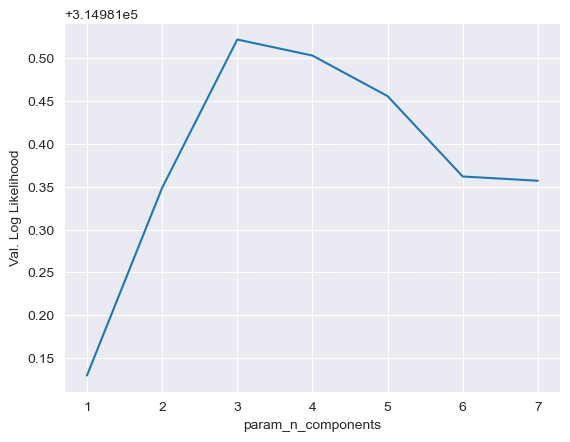

In [20]:
# Higher is better
sns.set_style("darkgrid")
sns.lineplot(data=results, x='param_n_components', y='Val. Log Likelihood', palette='Dark2')

In [18]:
#BLRT-sweep
# Define base model
model = stepmix.StepMix(n_components=3, n_steps=3, correction="BCH", measurement=mixed_descriptor,
                structural='bernoulli', random_state=42, verbose=0, progress_bar=0)

# Run BLRT sweep from 1 class to 4 classes
# Expect some convergence warnings
p_values = stepmix.bootstrap.blrt_sweep(model, mixed_data, y_females, low=1, high=7, n_repetitions=20)

Testing 1 vs. 2 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 20/20 [00:00<00:00, 34.25it/s, max_LL=-1.72e+4, median_LL=-1.75e+4, min_LL=-1.76e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    :   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :   5%|▌         | 1/20 [00:01<00:37,  1.96s/it, max_LL=-1.74e+4, median_LL=-1.74e+4, min_LL=-1.74e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  10%|█         | 2/20 [00:03<00:35,  1.99s/it, max_LL=-1.74e+4, median_LL=-1.74e+4, min_LL=-1.74e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for d

Testing 2 vs. 3 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 20/20 [00:04<00:00,  4.36it/s, max_LL=-1.7e+4, median_LL=-1.72e+4, min_LL=-1.74e+4] 



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    :   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :   5%|▌         | 1/20 [00:02<00:41,  2.19s/it, max_LL=-1.71e+4, median_LL=-1.71e+4, min_LL=-1.71e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  25%|██▌       | 5/20 [00:09<00:24,  1.65s/it, max_LL=-1.7e+4, median_LL=-1.71e+4, min_LL=-1.72e+4] c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for d

Testing 3 vs. 4 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    :  45%|████▌     | 9/20 [00:04<00:04,  2.21it/s, max_LL=-1.68e+4, median_LL=-1.69e+4, min_LL=-1.71e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    : 100%|██████████| 20/20 [00:11<00:00,  1.69it/s, max_LL=-1.68e+4, median_LL=-1.69e+4, min_LL=-1.72e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    :   5%|▌         | 1/20 [00:01<00:22,  1.18s/it, max_LL=-1.7e+4, median_LL=-1.7e+4, min_LL=-1.7e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  10%|█         | 2/20 [00:03<00:29,  1.67s/it, max_LL=-1.69e+4, median_LL=-1.69e+4, min_LL=-1.7e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  15%|█▌        | 3/20 [00:05<00:30,  1.82s/it, max_LL=-1.69e+4, median_LL=-1.69e+4, min_LL=-1.7e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init paramete

Testing 4 vs. 5 classes...


c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    :  35%|███▌      | 7/20 [00:10<00:18,  1.44s/it, max_LL=-1.67e+4, median_LL=-1.68e+4, min_LL=-1.69e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  50%|█████     | 10/20 [00:14<00:12,  1.28s/it, max_LL=-1.67e+4, median_LL=-1.68e+4, min_LL=-1.7e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  95%|█████████▌| 19/20 [00:27<00:01,  1.40s/it, max_LL=-1.67e+4, median_LL=-1.68e+4, min_LL=-1.7e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init par


Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    :   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :   5%|▌         | 1/20 [00:02<00:50,  2.66s/it, max_LL=-1.68e+4, median_LL=-1.68e+4, min_LL=-1.68e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  25%|██▌       | 5/20 [00:11<00:31,  2.08s/it, max_LL=-1.67e+4, median_LL=-1.68e+4, min_LL=-1.69e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for d

Testing 5 vs. 6 classes...


c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    :  10%|█         | 2/20 [00:07<01:06,  3.69s/it, max_LL=-1.67e+4, median_LL=-1.67e+4, min_LL=-1.67e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  20%|██        | 4/20 [00:15<01:00,  3.77s/it, max_LL=-1.67e+4, median_LL=-1.67e+4, min_LL=-1.68e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  35%|███▌      | 7/20 [00:23<00:37,  2.87s/it, max_LL=-1.67e+4, median_LL=-1.67e+4, min_LL=-1.68e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init par


Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    :   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  10%|█         | 2/20 [00:06<00:53,  2.98s/it, max_LL=-1.67e+4, median_LL=-1.67e+4, min_LL=-1.68e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  15%|█▌        | 3/20 [00:09<00:51,  3.00s/it, max_LL=-1.67e+4, median_LL=-1.68e+4, min_LL=-1.68e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for d

Testing 6 vs. 7 classes...


c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    :   5%|▌         | 1/20 [00:02<00:48,  2.57s/it, max_LL=-1.67e+4, median_LL=-1.67e+4, min_LL=-1.67e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  15%|█▌        | 3/20 [00:06<00:35,  2.12s/it, max_LL=-1.67e+4, median_LL=-1.68e+4, min_LL=-1.69e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  20%|██        | 4/20 [00:09<00:40,  2.52s/it, max_LL=-1.67e+4, median_LL=-1.68e+4, min_LL=-1.69e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init par


Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    :   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  10%|█         | 2/20 [00:04<00:38,  2.14s/it, max_LL=-1.66e+4, median_LL=-1.67e+4, min_LL=-1.68e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  15%|█▌        | 3/20 [00:07<00:40,  2.35s/it, max_LL=-1.66e+4, median_LL=-1.68e+4, min_LL=-1.68e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for d


BLRT Sweep Results
                    p
Test                 
1 vs. 2 classes  0.00
2 vs. 3 classes  0.00
3 vs. 4 classes  0.00
4 vs. 5 classes  0.80
5 vs. 6 classes  0.65
6 vs. 7 classes  0.95


In [37]:
p_values 

#Save the p-values as csv
p_values.to_csv("LRT_females_pvalues.csv")

In [25]:
#Declare number of classes to test
num_classes = range(1,8)
#loop over number of 
models = []
aics = []
bics = []
sabics = []
relative_entropies = []
n_parameters = []
loglikelihood=[]

#
for n_class in num_classes:
    #Estimate model with n_class classes
    model = stepmix.StepMix(n_components=n_class, 
                measurement=mixed_descriptor, 
                structural="bernoulli", 
                verbose=0,
                n_steps=3,
                correction="BCH",            
                random_state=42, 
                progress_bar=0)

    model.fit(mixed_data, y_females.drop(columns=["CASE"]))

    #Add model and metrics
    models.append(model)
    loglikelihood.append(model.score(mixed_data, y_females.drop(columns=["CASE"])))
    aics.append(model.aic(mixed_data, y_females.drop(columns=["CASE"])))
    bics.append(model.bic(mixed_data, y_females.drop(columns=["CASE"])))
    sabics.append(model.sabic(mixed_data, y_females.drop(columns=["CASE"])))
    relative_entropies.append(model.relative_entropy(mixed_data, y_females.drop(columns=["CASE"])))
    n_parameters.append(model.n_parameters)


c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


In [23]:
relative_entropies

[nan,
 0.6496830296853016,
 0.6739706372351683,
 0.6557258325577652,
 0.6514068531127981,
 0.6364642841035979,
 0.6949866080679896]

In [18]:
#Use the magic %%capture command of jupyter notebook to save the console output to the variable cap
%%capture cap

models[2].report(mixed_data, y_females.drop(columns=["CASE"]))



UsageError: Line magic function `%%capture` not found.


In [10]:
# Save the captured results in variable cap output to a text file
with open('results_females_k3.txt', 'w') as file:
    file.write(cap.stdout)

In [29]:
import pickle
#Save the models as a pickle
with open('stepmix_models_females.pkl', 'wb') as file:
    pickle.dump(models, file)

In [27]:
#See whether models reached convergence criterion
converged = []
for model_i in range(len(models)):
    converged.append(models[model_i].converged_)



In [35]:
#Save the fitmeasures of each 
n_classes = [1,2,3,4,5,6,7]
fit_measures = pd.DataFrame(list(zip(n_classes, loglikelihood, n_parameters, aics, bics, sabics, relative_entropies, n_parameters, converged)), columns=["n_classes", "loglikelihood","n_parameters", "aics", "bics", "sabics", "relative_entropies", "n_parameters", "convergence"])
fit_measures.to_csv("fit_measures_females.csv")

In [30]:
fit_measures

,n_classes,aics,bics,sabics,relative_entropies,convergence
0,1,35050.893296,35261.229782,35424.500413,NaN,True
1,2,34467.062266,34892.993650,35223.616678,0.649683,True
2,3,33931.074732,34572.601014,35070.576440,0.673971,True
3,4,33776.492269,34633.613449,35298.941271,0.655726,True
4,5,33848.311308,34921.027387,35753.707606,0.651407,False
5,6,33910.532516,35198.843493,36198.876109,0.636464,False
6,7,34030.419749,35534.325624,36701.710637,0.694987,False


Get infos from emission models: https://stepmix.readthedocs.io/en/latest/api.html#emission-models


In [36]:
models[2].get_parameters_df().to_csv("parameters_females_k3.csv")

Get bootstrapped parameter estimates from the winning model 

In [23]:
models[2].n_parameters

122

In [33]:
bootstrapped_stats = models[2].bootstrap_stats(mixed_data, y_females.drop(columns=["CASE"]), n_repetitions=500)


Bootstrapping estimator...


Bootstrap Repetitions    :   2%|▏         | 9/500 [00:03<03:54,  2.10it/s, max_LL=-1.68e+4, median_LL=-1.69e+4, min_LL=-1.71e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  22%|██▏       | 112/500 [00:59<04:57,  1.30it/s, max_LL=-1.67e+4, median_LL=-1.69e+4, min_LL=-1.72e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
Bootstrap Repetitions    :  28%|██▊       | 138/500 [01:15<02:31,  2.39it/s, max_LL=-1.67e+4, median_LL=-1.69e+4, min_LL=-1.72e+4]c:\Users\gniel\anaconda3\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different i

In [14]:
#Save the bootstrapped values as pickle and csv
import pickle
#as pickle
with open("bootstrapped_stats_k3.pkl", "wb") as file:
    pickle.dump(bootstrapped_stats, file)

#samples as csv
bootstrapped_stats["samples"].to_csv("bootstrapped_samples_k3.csv")

NameError: name 'bootstrapped_stats' is not defined

In [33]:
#Create a class predicitons dataframe with n*n_class rows and 
prediction_list = []

for model_i in range(len(models)):
    n_classes = np.repeat(model_i+1, mixed_data.shape[0])
    class_predictions_arr = pd.DataFrame(models[model_i].predict_proba(mixed_data))
    class_predictions_arr["n_classes"] = n_classes.tolist()

    prediction_list.append(class_predictions_arr)

prediction_frame = pd.concat(prediction_list, axis=0)
prediction_frame.to_csv("posterior_class_probs_females.csv")
    
    